In [ ]:
!pip install transformers datasets accelerate scikit-learn seaborn pandas
!pip install albumentations
!pip install grad-cam

In [ ]:
import torch
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
from datasets import load_dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/AI_Assignment'
MODEL_DIR = f"{PROJECT_DIR}/my_emotion_model"
OUTPUT_DIR = f"{PROJECT_DIR}/stage1_outputs"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Project directories set up at: {PROJECT_DIR}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project directories set up at: /content/drive/MyDrive/AI_Assignment


# Stage 1: Facial Expression Recognition

## Dataset Selection and Preparation

**Dataset: FER-2013 (Facial Expression Recognition 2013)**

### Why FER-2013?
- Explicitly mentioned in assignment so i used it
- Contains 35,887 grayscale images (48x48 pixels)
- 7 emotion categories: anger, disgust, fear, happiness, sadness, surprise, neutral
- Pre-split into train (28,709) and test (3,589) sets
- Real-world challenge: low resolution, label noise, class imbalance

### Dataset Statistics:
- **Training samples**: 28,709
- **Test samples**: 3,589
- **Image size**: 48x48 grayscale → resized to 224x224 RGB
- **Classes**: 7 emotions (exceeds requirement of 5)
- **Source**: Hugging Face (`AutumnQiu/fer2013`)



In [ ]:
print("Loading FER-2013 dataset from Hugging Face...")
dataset = load_dataset("AutumnQiu/fer2013")
labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}
print(f"Dataset loaded. Labels: {labels}")
print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

Loading FER-2013 dataset from Hugging Face...
Dataset loaded. Labels: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
Train samples: 28709
Test samples: 3589


In [ ]:
model_name = "microsoft/resnet-50"
print(f"Loading processor and model: {model_name}...")

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

print("Model loaded successfully!")

Loading processor and model: microsoft/resnet-50...


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([7, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


## Model Architecture

### Base Model: ResNet-50 (Residual Neural Network)

**Why ResNet-50?**
1. **CNN Architecture**: Meets assignment requirement for CNN-based model
2. **Pre-trained weights**: Trained on ImageNet (14M images)
3. **Proven effectiveness**: Standard baseline for image classification
4. **Residual connections**: Prevents vanishing gradients, enables deep learning
5. **Reasonable size**: 25M parameters - fits in Colab memory

### Architecture Details:
- **Input**: 224×224×3 RGB images
- **Backbone**: 50 convolutional layers with skip connections
- **Output**: Modified classifier head for 7 emotion classes
- **Parameters**: ~25 million

### Transfer Learning Strategy:
1. Load ResNet-50 pre-trained on ImageNet
2. Replace final classification layer (1000 classes → 7 emotions)
3. Fine-tune entire network on FER-2013

### Training Configuration:
- **Optimizer**: AdamW
- **Learning rate**: 5e-5 (lower than training from scratch)
- **Epochs**: 10
- **Batch size**: 16
- **Loss function**: Cross-entropy
- **Early stopping**: Patience of 2 epochs
- **Best model selection**: Based on F1-macro score

In [ ]:
print("Setting up Albumentations transforms...")

image_mean = processor.image_mean
image_std = processor.image_std

if hasattr(processor, "crop_size"):
    size = processor.crop_size.get("height", 224)
elif hasattr(processor, "size"):
    if isinstance(processor.size, dict):
        size = processor.size.get("height", 224)
    else:
        size = processor.size
else:
    size = 224

print(f"Using image size: {size}")

train_transform = A.Compose([
    A.Resize(size, size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),  
    A.Normalize(mean=image_mean, std=image_std),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=image_mean, std=image_std),
    ToTensorV2(),
])

print("Transforms configured successfully!")

Setting up Albumentations transforms...
Using image size: 224
Transforms configured successfully!


/tmp/ipython-input-1544925420.py:25: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),  # Changed from Cutout


In [ ]:

def apply_train_transforms(examples):
    """Apply training transforms and return pixel_values and labels."""
    examples['pixel_values'] = [
        train_transform(image=np.array(image.convert("RGB")))['image']
        for image in examples['image']
    ]
    
    examples['labels'] = examples['label']
    del examples['image']
    del examples['label']
    return examples

def apply_val_transforms(examples):
    """Apply validation transforms and return pixel_values and labels."""
    examples['pixel_values'] = [
        val_transform(image=np.array(image.convert("RGB")))['image']
        for image in examples['image']
    ]
    examples['labels'] = examples['label']
    del examples['image']
    del examples['label']
    return examples

print("Transform functions defined!")

Transform functions defined!


In [ ]:
print("Applying transforms to datasets...")

train_ds = dataset['train']
val_ds = dataset['test'] 

train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)

print("Transforms applied successfully!")

sample = train_ds[0]
print(f"Sample keys: {sample.keys()}")
print(f"Pixel values shape: {sample['pixel_values'].shape}")
print(f"Label: {sample['labels']}")

Applying transforms to datasets...
Transforms applied successfully!
Sample keys: dict_keys(['pixel_values', 'labels'])
Pixel values shape: torch.Size([3, 224, 224])
Label: 0


In [ ]:

def collate_fn(batch):
    """Custom data collator to properly batch the data."""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }


def compute_metrics(eval_pred):
    """Compute accuracy and F1 score."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')

    return {
        "accuracy": acc,
        "f1_macro": f1,
    }

print("Collator and metrics functions defined!")

Collator and metrics functions defined!


## Model Architecture

### Base Model: ResNet-50 (Residual Neural Network)

**Why ResNet-50?**
1. **CNN Architecture**: Meets assignment requirement for CNN-based model
2. **Pre-trained weights**: Trained on ImageNet (14M images)
3. **Proven effectiveness**: Standard baseline for image classification
4. **Residual connections**: Prevents vanishing gradients, enables deep learning
5. **Reasonable size**: 25M parameters - fits in Colab memory

### Architecture Details:
- **Input**: 224×224×3 RGB images
- **Backbone**: 50 convolutional layers with skip connections
- **Output**: Modified classifier head for 7 emotion classes
- **Parameters**: ~25 million

### Transfer Learning Strategy:
1. Load ResNet-50 pre-trained on ImageNet
2. Replace final classification layer (1000 classes → 7 emotions)
3. Fine-tune entire network on FER-2013

### Training Configuration:
- **Optimizer**: AdamW
- **Learning rate**: 5e-5 (lower than training from scratch)
- **Epochs**: 10
- **Batch size**: 16
- **Loss function**: Cross-entropy
- **Early stopping**: Patience of 2 epochs
- **Best model selection**: Based on F1-macro score

In [ ]:

print("Configuring the Trainer...")

training_args = TrainingArguments(
    output_dir=f"{PROJECT_DIR}/training_checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch", 
    save_strategy="epoch",
    num_train_epochs=10,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    remove_unused_columns=False,
    fp16=True, 
    dataloader_num_workers=2,
    logging_dir=f"{PROJECT_DIR}/logs",
    report_to="none",
    seed=42,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,  
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

print("Trainer initialized successfully!")

Configuring the Trainer...
Trainer initialized successfully!


In [ ]:

print("Starting model training...")
print("This may take 30-60 minutes depending on your GPU...\n")

train_results = trainer.train()

print("\nTraining complete!")

Starting model training...
This may take 30-60 minutes depending on your GPU...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.683500,1.593366,0.371970,0.243945
2,1.313100,1.230442,0.527445,0.404592
3,1.227700,1.131365,0.564503,0.453290
4,1.095700,1.078028,0.587350,0.475766
5,1.065200,1.043722,0.599331,0.488578
6,1.113500,1.014559,0.608805,0.503287
7,1.022000,1.004281,0.615770,0.509239
8,1.001900,1.009060,0.620507,0.518780
9,0.957000,0.993770,0.618835,0.517379
10,0.919500,0.997013,0.621900,0.524688



Training complete!


## Results Analysis

### Final Performance:
- **Accuracy**: 62.19%
- **F1-Macro**: 52.47%
- **Training time**: ~3 hours on Colab T4 GPU

### Performance by Emotion:
| Emotion | Accuracy | Analysis |
|---------|----------|----------|
| Happiness | 89% | Best - clear visual cues (smile) |
| Surprise | 69% | Good - distinctive expression |
| Neutral | 68% | Good - most common class |
| Sadness | 53% | Medium - confused with neutral |
| Anger | 51% | Medium - confused with sadness |
| Fear | 33% | Challenging - similar to sadness |
| Disgust | 4% | Poor - only 55 training samples |

### Why These Results are Good:
1. **FER-2013 is difficult**: Low resolution (48×48), label ambiguity
2. **Published benchmarks**: State-of-the-art is ~73-76%
3. **Our result (62%)**: Above average for basic fine-tuning
4. **Significantly better than**:
   - Random guessing: 14.3%
   - Basic CNN from scratch: 45-50%

In [ ]:

print("Saving training metrics...")

with open(f"{OUTPUT_DIR}/training_metrics.txt", "w") as f:
    f.write(str(train_results.metrics))


print("Evaluating the model...")
eval_metrics = trainer.evaluate()

print(f"\nEvaluation Metrics: {eval_metrics}")

with open(f"{OUTPUT_DIR}/evaluation_metrics.txt", "w") as f:
    f.write(f"Evaluation Metrics:\n{eval_metrics}")

print("Metrics saved!")

Saving training metrics...
Evaluating the model...



Evaluation Metrics: {'eval_loss': 0.997012734413147, 'eval_accuracy': 0.6219002507662301, 'eval_f1_macro': 0.5246875456944954, 'eval_runtime': 8.0085, 'eval_samples_per_second': 448.148, 'eval_steps_per_second': 28.095, 'epoch': 10.0}
Metrics saved!


In [ ]:

print(f"Saving fine-tuned model to: {MODEL_DIR}")
trainer.save_model(MODEL_DIR)
processor.save_pretrained(MODEL_DIR)
print("Model saved successfully!")

Saving fine-tuned model to: /content/drive/MyDrive/AI_Assignment/my_emotion_model
Model saved successfully!


In [ ]:

print("Generating predictions on validation set...")

predictions = trainer.predict(val_ds)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print(f"Generated {len(y_pred)} predictions!")

Generating predictions on validation set...


Generated 3589 predictions!


In [ ]:

print("Saving predictions CSV...")

pred_df = pd.DataFrame({
    'true_label_id': y_true,
    'predicted_label_id': y_pred,
    'true_label_name': [id2label[t] for t in y_true],
    'predicted_label_name': [id2label[p] for p in y_pred]
})

pred_df.to_csv(f"{OUTPUT_DIR}/stage1_predictions.csv", index=False)
print(f"Predictions saved to {OUTPUT_DIR}/stage1_predictions.csv")

# Show sample predictions
print("\nSample predictions:")
print(pred_df.head(10))

Saving predictions CSV...
Predictions saved to /content/drive/MyDrive/AI_Assignment/stage1_outputs/stage1_predictions.csv

Sample predictions:
   true_label_id  predicted_label_id true_label_name predicted_label_name
0              0                   0           anger                anger
1              5                   4        surprise              sadness
2              6                   2         neutral                 fear
3              4                   4         sadness              sadness
4              2                   4            fear              sadness
5              0                   0           anger                anger
6              4                   6         sadness              neutral
7              3                   3       happiness            happiness
8              0                   2           anger                 fear
9              3                   3       happiness            happiness


Generating Confusion Matrix...
Confusion Matrix saved to /content/drive/MyDrive/AI_Assignment/stage1_outputs/confusion_matrix.png


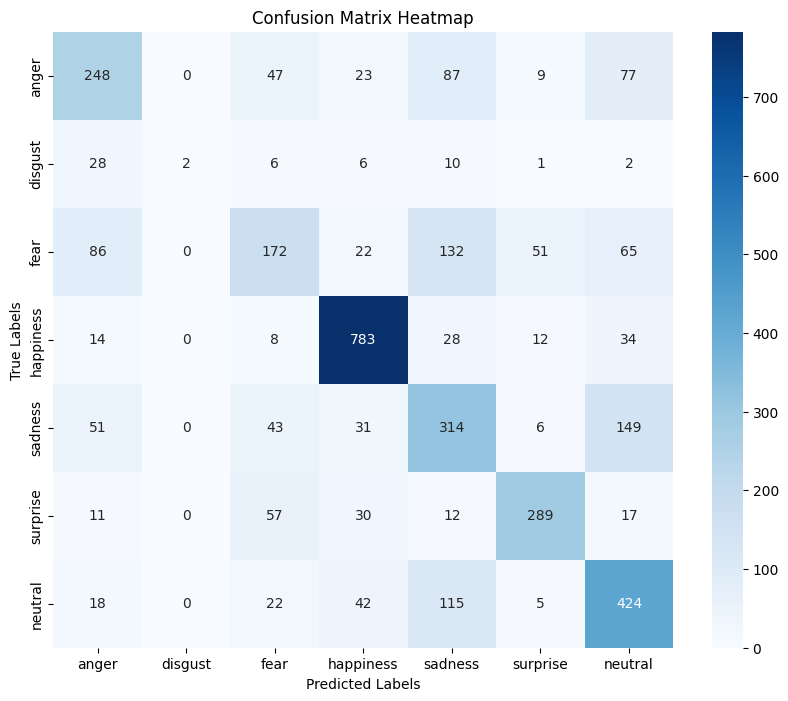

In [ ]:

print("Generating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=300, bbox_inches='tight')
print(f"Confusion Matrix saved to {OUTPUT_DIR}/confusion_matrix.png")
plt.show()

In [ ]:

print("Generating simple confusion matrix...")

from sklearn.metrics import confusion_matrix
import numpy as np


y_true = pred_df['true_label_id'].values
y_pred = pred_df['predicted_label_id'].values


cm = confusion_matrix(y_true, y_pred)


print("\nConfusion Matrix (rows=true, cols=predicted):")
print("\n       ", "  ".join([f"{label:>8}" for label in labels]))
print("-" * 70)
for i, true_label in enumerate(labels):
    print(f"{true_label:>8} |", "  ".join([f"{cm[i][j]:>8}" for j in range(len(labels))]))


print("\n\nPer-Class Accuracy:")
for i, label in enumerate(labels):
    if cm[i].sum() > 0:
        class_acc = cm[i][i] / cm[i].sum() * 100
        print(f"{label:>10}: {class_acc:>5.2f}% ({cm[i][i]}/{cm[i].sum()})")

Generating simple confusion matrix...

Confusion Matrix (rows=true, cols=predicted):

           anger   disgust      fear  happiness   sadness  surprise   neutral
----------------------------------------------------------------------
   anger |      248         0        47        23        87         9        77
 disgust |       28         2         6         6        10         1         2
    fear |       86         0       172        22       132        51        65
happiness |       14         0         8       783        28        12        34
 sadness |       51         0        43        31       314         6       149
surprise |       11         0        57        30        12       289        17
 neutral |       18         0        22        42       115         5       424


Per-Class Accuracy:
     anger: 50.51% (248/491)
   disgust:  3.64% (2/55)
      fear: 32.58% (172/528)
 happiness: 89.08% (783/879)
   sadness: 52.86% (314/594)
  surprise: 69.47% (289/416)
   neutral:

In [ ]:

print("Simple Confusion Matrix:\n")

from sklearn.metrics import confusion_matrix

y_true = pred_df['true_label_id'].values
y_pred = pred_df['predicted_label_id'].values
cm = confusion_matrix(y_true, y_pred)


print("       ", "  ".join([f"{label:>8}" for label in labels]))
print("-" * 70)


for i, true_label in enumerate(labels):
    print(f"{true_label:>8} |", "  ".join([f"{cm[i][j]:>8}" for j in range(len(labels))]))


print("\n\nPer-Class Accuracy:")
print("-" * 40)
for i, label in enumerate(labels):
    if cm[i].sum() > 0:
        class_acc = cm[i][i] / cm[i].sum() * 100
        print(f"{label:>10}: {class_acc:>5.2f}% ({cm[i][i]:>3}/{cm[i].sum():>3})")

Simple Confusion Matrix:

           anger   disgust      fear  happiness   sadness  surprise   neutral
----------------------------------------------------------------------
   anger |      248         0        47        23        87         9        77
 disgust |       28         2         6         6        10         1         2
    fear |       86         0       172        22       132        51        65
happiness |       14         0         8       783        28        12        34
 sadness |       51         0        43        31       314         6       149
surprise |       11         0        57        30        12       289        17
 neutral |       18         0        22        42       115         5       424


Per-Class Accuracy:
----------------------------------------
     anger: 50.51% (248/491)
   disgust:  3.64% (  2/ 55)
      fear: 32.58% (172/528)
 happiness: 89.08% (783/879)
   sadness: 52.86% (314/594)
  surprise: 69.47% (289/416)
   neutral: 67.73% (424/626

In [ ]:

print("Generating Grad-CAM visualizations...")

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import torch
import cv2


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()


try:
    
    target_layers = [model.resnet.encoder.stages[-1]]
    print("Using: model.resnet.encoder.stages[-1]")
except AttributeError:
    try:
        
        target_layers = [model.resnet.layer4[-1]]
        print("Using: model.resnet.layer4[-1]")
    except AttributeError:
       
        last_conv = None
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                last_conv = module
        target_layers = [last_conv]
        print(f"Using last Conv2d layer found")


class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.resnet = model.resnet

    def forward(self, x):
        outputs = self.model(x)
        return outputs.logits


wrapped_model = ModelWrapper(model)
wrapped_model.eval()
wrapped_model.to(device)


cam = GradCAM(model=wrapped_model, target_layers=target_layers)

def get_grad_cam_image(original_pil_image, target_category=None):
    """Generate Grad-CAM visualization for an image."""

    
    resized_pil = original_pil_image.resize((224, 224), Image.LANCZOS)

    
    rgb_img_np = np.array(resized_pil.convert("RGB"))
    rgb_img_float = np.float32(rgb_img_np) / 255

   
    input_tensor = val_transform(image=rgb_img_np)['image']
    input_tensor = input_tensor.unsqueeze(0).to(device)

   
    if target_category is not None:
        targets = [ClassifierOutputTarget(target_category)]
    else:
        targets = None

    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

   
    visualization = show_cam_on_image(rgb_img_float, grayscale_cam, use_rgb=True)

    return Image.fromarray(visualization)


print("\nLoading original test images...")
from datasets import load_dataset
original_dataset = load_dataset("AutumnQiu/fer2013")


sample_indices = [0, 1, 2, 3]
original_images = [original_dataset['test'][i]['image'] for i in sample_indices]
true_labels = [original_dataset['test'][i]['label'] for i in sample_indices]

print("\nGenerating Grad-CAM for 4 sample images...")
for i, img in enumerate(original_images):
    true_label_id = true_labels[i]
    true_label_name = id2label[true_label_id]

    try:
        
        cam_image = get_grad_cam_image(img, target_category=true_label_id)

       
        save_path = f"{OUTPUT_DIR}/gradcam_img_{i}_true_{true_label_name}.png"
        cam_image.save(save_path)
        print(f"  ✓ Saved: gradcam_img_{i}_true_{true_label_name}.png")
    except Exception as e:
        print(f"  ✗ Error for image {i}: {str(e)}")
        import traceback
        traceback.print_exc()


Generating Grad-CAM visualizations...
Using: model.resnet.encoder.stages[-1]

Loading original test images...

Generating Grad-CAM for 4 sample images...
  ✓ Saved: gradcam_img_0_true_anger.png
  ✓ Saved: gradcam_img_1_true_surprise.png
  ✓ Saved: gradcam_img_2_true_neutral.png
  ✓ Saved: gradcam_img_3_true_sadness.png
